In [1]:
from mongo import *
%matplotlib inline

In [2]:
(features, pool, likes, users, user_hot, user_num) = gather_mongo_data()

In [3]:
data = split_datasets(users, user_hot, features, likes)

Seed value is: 0
Training set length: 66749
Test set length: 2367
Validation set length: 2450


In [4]:
import tensorflow as tf

In [5]:
x = tf.placeholder(tf.float32, shape=[None, 2051])
y_ = tf.placeholder(tf.float32, shape=[None, 1])

In [6]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

In [7]:
def variable_summaries(var, name):
    """Attach a lot of summaries to a Tensor."""
    with tf.name_scope('summaries'):
        mean = tf.reduce_mean(var)
        tf.scalar_summary('mean/' + name, mean)
    with tf.name_scope('stddev'):
        stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
    tf.scalar_summary('sttdev/' + name, stddev)
    tf.scalar_summary('max/' + name, tf.reduce_max(var))
    tf.scalar_summary('min/' + name, tf.reduce_min(var))
    tf.histogram_summary(name, var)

In [8]:
def nn_layer(input_tensor, input_dim, output_dim, layer_name, act=tf.nn.sigmoid):
    """Reusable code for making a simple neural net layer.

    It does a matrix multiply, bias add, and then uses relu to nonlinearize.
    It also sets up name scoping so that the resultant graph is easy to read,
    and adds a number of summary ops.
    """
    # Adding a name scope ensures logical grouping of the layers in the graph.
    with tf.name_scope(layer_name):
        # This Variable will hold the state of the weights for the layer
        with tf.name_scope('weights'):
            weights = weight_variable([input_dim, output_dim])
            variable_summaries(weights, layer_name + '/weights')
        with tf.name_scope('biases'):
            biases = bias_variable([output_dim])
            variable_summaries(biases, layer_name + '/biases')
        with tf.name_scope('Wx_plus_b'):
            preactivate = tf.matmul(input_tensor, weights) + biases
            tf.histogram_summary(layer_name + '/pre_activations', preactivate)
        
        if act is not None:
            activations = act(preactivate, 'activation')
            tf.histogram_summary(layer_name + '/activations', activations)
            return activations
        else:
            return preactivate

In [9]:
hidden1 = nn_layer(x, 2051, 1000, 'layer1')

In [10]:
with tf.name_scope('dropout1'):
    keep_prob = tf.placeholder(tf.float32)
    tf.scalar_summary('dropout1_keep_probability', keep_prob)
    dropped1 = tf.nn.dropout(hidden1, keep_prob)

In [11]:
hidden2 = nn_layer(dropped1, 1000, 500, 'layer2')

In [12]:
# with tf.name_scope('dropout2'):
#     tf.scalar_summary('dropout2_keep_probability', keep_prob)
#     dropped2 = tf.nn.dropout(hidden2, keep_prob)

In [13]:
with tf.name_scope('prediction'):
    y = nn_layer(hidden2, 500, 1, 'layer3', act=None)
    variable_summaries(y, 'y')
    variable_summaries(y_, 'y_')

In [67]:
with tf.name_scope('error'):    
    abs_error = tf.abs(y_ - y)
    variable_summaries(abs_error, 'abs_error')
    
    with tf.name_scope('total'):
        mse = tf.sqrt(tf.reduce_mean(tf.square(y_ - y)))
    
    tf.scalar_summary('mse', mse)

In [68]:
with tf.name_scope('train'):
    train_step = tf.train.AdamOptimizer(learning_rate = 1e-5).minimize(mse)

In [14]:
sess = tf.InteractiveSession()

In [70]:
# Merge all the summaries and write them out to /tmp/mnist_logs (by default)
merged = tf.merge_all_summaries()

train_writer = tf.train.SummaryWriter('logs_fb/train', sess.graph)
test_writer = tf.train.SummaryWriter('logs_fb/test')
tf.initialize_all_variables().run()

In [17]:
# Train the model, and also write summaries.
# Every 10th step, measure test-set accuracy, and write test summaries
# All other steps, run train_step on training data, & add training summaries

def feed_dict(train):
    """Make a TensorFlow feed_dict: maps data onto Tensor placeholders."""
    if train:
        cv = np.random.choice(len(data["training"]["y"]), 500)
        xs = data["training"]["X"][cv, :]
        ys = data["training"]["y"][cv]
        k = 0.5
    else:
        xs, ys = data["validation"]["X"], data["validation"]["y"]
        k = 1.0
    return {x: xs, y_: ys, keep_prob: k}

In [22]:
saver = tf.train.Saver()
summary, acc = sess.run([merged, mse], feed_dict=feed_dict(False))

In [19]:
for i in range(0, 20000):
    if i % 10 == 0:  # Record summaries and test-set accuracy
        summary, acc = sess.run([merged, mse], feed_dict=feed_dict(False))
        test_writer.add_summary(summary, i)
        print('Accuracy at step %s: %s' % (i, acc))
        
        if i % 1000 == 0:
            save_path = saver.save(sess, "checkpoints/" + str(i) + "_" + str(acc) + ".ckpt")
            print("Model saved in file: %s" % save_path)
        
    else:  # Record train set summaries, and train
        summary, _ = sess.run([merged, train_step], feed_dict=feed_dict(True))
        train_writer.add_summary(summary, i)

Accuracy at step 0: 0.548517
Model saved in file: checkpoints/0_0.548517.ckpt
Accuracy at step 10: 0.551083
Accuracy at step 20: 0.543582
Accuracy at step 30: 0.545209
Accuracy at step 40: 0.532638
Accuracy at step 50: 0.532696
Accuracy at step 60: 0.530401
Accuracy at step 70: 0.526198
Accuracy at step 80: 0.523369
Accuracy at step 90: 0.522974
Accuracy at step 100: 0.524463
Accuracy at step 110: 0.514772
Accuracy at step 120: 0.516666
Accuracy at step 130: 0.511389
Accuracy at step 140: 0.509778
Accuracy at step 150: 0.514837
Accuracy at step 160: 0.510028
Accuracy at step 170: 0.504899
Accuracy at step 180: 0.507955
Accuracy at step 190: 0.506716
Accuracy at step 200: 0.500839
Accuracy at step 210: 0.508465
Accuracy at step 220: 0.504493
Accuracy at step 230: 0.498396
Accuracy at step 240: 0.501625
Accuracy at step 250: 0.503585
Accuracy at step 260: 0.499416
Accuracy at step 270: 0.499402
Accuracy at step 280: 0.496281
Accuracy at step 290: 0.497475
Accuracy at step 300: 0.492037
A

In [15]:
restorer = tf.train.Saver(tf.all_variables())
restorer.restore(sess, "checkpoints/14000_0.462424.ckpt")

In [18]:
pred_likes = sess.run([y], feed_dict=feed_dict(False))[0]

In [ ]:
from sklearn import linear_model
plt.scatter(data['validation']['y'], pred_likes)
lin = linear_model.LinearRegression().fit(data['validation']['y'], pred_likes)
plt.plot(data['validation']['y'], data['validation']['y'] * lin.coef_ + lin.intercept_, color='red', linewidth='2')
plt.title('Neural network performance')
plt.xlabel('Actual log-likes')
plt.ylabel('Predicted log-likes')
plt.tight_layout()
plt.savefig('nn_performance.png', dpi=300)
print(lin.score(data['validation']['y'], pred_likes))

In [37]:
pred_likes = pred_likes[0]

In [38]:
calculate_correct_comparisons(data["validation"]["observations"], data["validation"]["users"], user_hot, pred_likes, data["validation"]["y"])

0.5591960399419647

In [ ]:
saver.save(sess, "/Users/loganw/checkpoints/" + str(i) + "_" + str(acc) + ".ckpt")

In [ ]:
saver = tf.train.Saver()
saver.restore(sess, "/Users/loganw/checkpoints/33000_0.486926.ckpt")
xs, ys = validation_x, validation_y
k = 1.0
validation_y_pred_nn, acc = sess.run([y, mse], feed_dict={x: xs, y_: ys, keep_prob: k})
print(acc)

lrnr = sklearn.linear_model.LinearRegression()

lrnr.fit(validation_y, validation_y_pred_nn)
print(lrnr.score(validation_y, validation_y_pred_nn))

plt.scatter(validation_y, validation_y_pred_nn)
plt.plot(validation_y, validation_y * lrnr.coef_ + lrnr.intercept_, color='red', linewidth=2)

In [ ]:
saver = tf.train.Saver()
saver.restore(sess, "/Users/loganw/checkpoints/39999_0.488391.ckpt")
xs, ys = validation_x, validation_y
k = 1.0
validation_y_pred_nn, acc = sess.run([y, mse], feed_dict={x: xs, y_: ys, keep_prob: k})
print(acc)

lrnr = sklearn.linear_model.LinearRegression()

lrnr.fit(validation_y, validation_y_pred_nn)
print(lrnr.score(validation_y, validation_y_pred_nn))

plt.scatter(validation_y, validation_y_pred_nn)
plt.plot(validation_y, (validation_y * lrnr.coef_ + lrnr.intercept_), color='red', linewidth=2)

In [ ]:
import matplotlib.pyplot as plt
import seaborn
%matplotlib inline
import sklearn.linear_model

In [ ]:
simple_linear = sklearn.linear_model.LinearRegression()
simple_linear.fit(training_x, training_y)
print(simple_linear.score(validation_x, validation_y))

validation_y_pred = simple_linear.predict(validation_x)

lrnr = sklearn.linear_model.LinearRegression()

lrnr.fit(validation_y, validation_y_pred)
print(lrnr.score(validation_y, validation_y_pred))

plt.scatter(validation_y, validation_y_pred)
plt.plot(validation_y, validation_y * lrnr.coef_ + lrnr.intercept_, color='red', linewidth=2)

In [ ]:
plt.scatter(validation_y_pred, validation_y_pred_nn)

In [ ]:
xs, ys = validation_x, validation_y
k = 1.0
validation_y_pred, acc = sess.run([y, mse], feed_dict={x: xs, y_: ys, keep_prob: k})

r^2: 0.0219105253392
r^2: 0.0419654812469
r^2: 0.0553210791079
r^2: 0.0184741936383
r^2: 0.0212088515637
r^2: 0.0111079133765
r^2: 0.000363076160848
r^2: 0.0702479645101
r^2: 0.0125250510207
r^2: 0.159106194102
r^2: 0.00228517967313
r^2: 0.168619555341
r^2: 0.00425702736383
r^2: 0.0506905191236
r^2: 0.0167290134063
r^2: 0.000984732690219
r^2: 0.140541827591
r^2: 0.000680559675905
r^2: 0.0297390622347
r^2: 0.0403942593829
r^2: 0.0391192110971
r^2: 0.00040320315691
r^2: 0.00715194318785
r^2: 0.0398125495864
r^2: 0.000513977470531
r^2: 0.0690557154258
r^2: 0.000496182012277
r^2: 0.0364780616784
r^2: 0.0547700032127
r^2: 0.0117136837977
r^2: 0.0418975692546
r^2: 0.000366845110813
r^2: 0.000152892457278
r^2: 0.0015302517929
r^2: 0.0585082335828


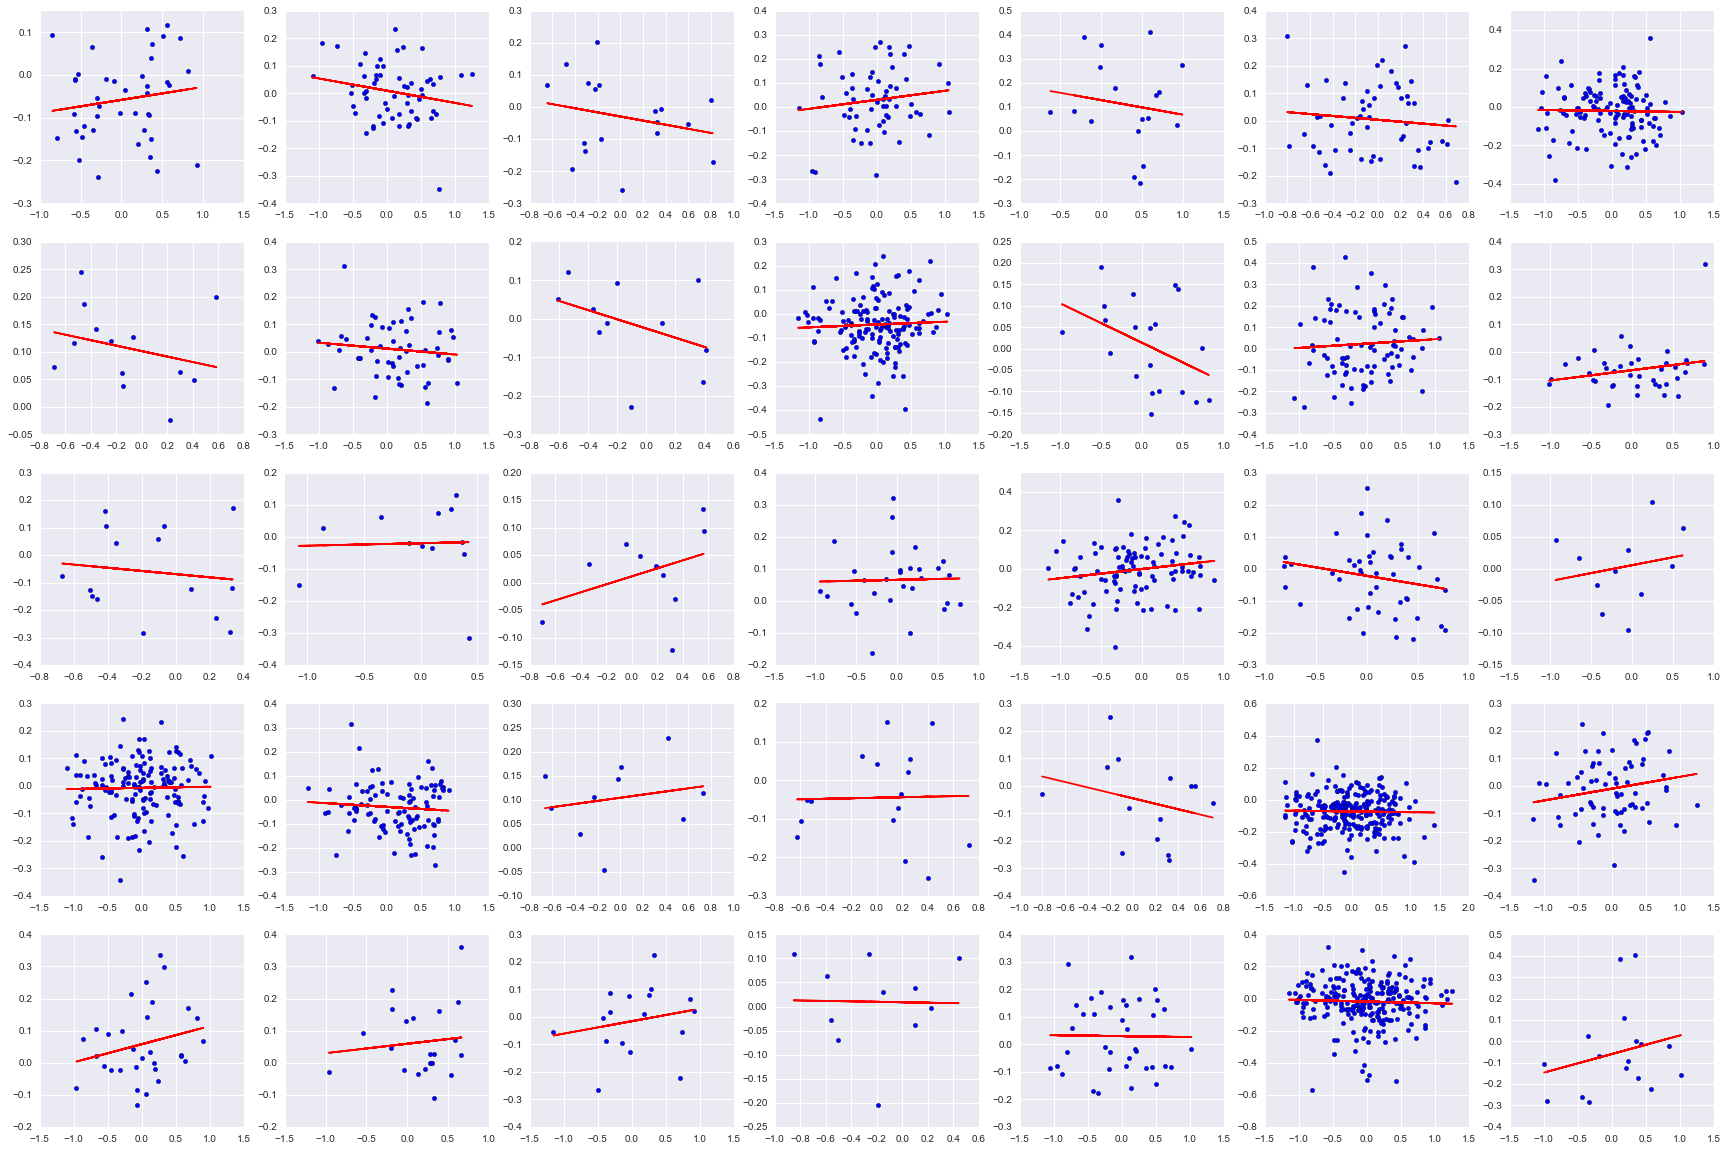

In [19]:
j = 1
plt.figure(figsize=(30, 20))
user_validation = user_hot[data["validation"]["observations"],:]

for i in range(len(data["validation"]["users"])):
    user_test_set = np.any(user_validation[:, [data["validation"]["users"][i]]], axis = 1).nonzero()[0]
    
    if (len(user_test_set)) >= 10:
        plt.subplot(5, 7, j)
        j += 1
        
#         user_dict = {}
#         user_dict[x] = data["validation"]["X"][user_test_set,:]
#         user_dict[y_] = data["validation"]["y"][user_test_set,:] * 0
#         user_dict[keep_prob] = 1.0
        
        ypred = pred_likes[user_test_set]
#         sess.run([y], feed_dict=user_dict)[0]

        y = np.ravel(likes[user_test_set])
        plt.scatter(y, ypred)
#         print('rmse:' + str(calculate_rmse(y, ypred)))

        lin = linear_model.LinearRegression()
        lin.fit(y.reshape((-1, 1)), ypred)
        plt.plot(y.reshape(-1,1), y.reshape(-1,1) * lin.coef_ + lin.intercept_, 'r')
        print("r^2: " + str(lin.score(y.reshape(-1,1), ypred)))

plt.savefig("nn_user_performance.png", dpi=300)

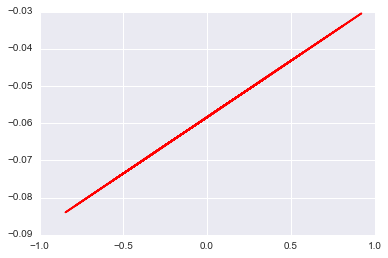

In [51]:
plt.plot(y.reshape(-1,1), y.reshape(-1,1) * lin.coef_ + lin.intercept_, 'r')